In [1]:
import skimage.io as io
import skimage.feature as feature
import skimage.filters as filters
import matplotlib.pyplot as plt
import numpy as np
#von mises
from scipy.stats import vonmises
import cmocean
%matplotlib inline

In [26]:
def angles_for_windows(theta, scale_factor=100,von_mises=True):
    ylen,xlen = theta.shape
    ysteps=ylen/scale_factor
    xsteps=xlen/scale_factor
    angles=np.zeros((ysteps,xsteps))

    for ystep in range(ysteps):
        for xstep in range(xsteps):
            fov=theta[ystep*scale_factor:(ystep+1)*scale_factor,xstep*scale_factor:(xstep+1)*scale_factor]
            
            if von_mises:
            #von mises is optimal but slow. Try histogram max
                kappa,angles[ystep,xstep],n=vonmises.fit(np.ndarray.flatten(fov))
            else:
                n,bins=np.histogram(np.ndarray.flatten(fov),64)
                angles[ystep,xstep]=bins[np.argmax(n)]
            
            
    return angles

def rgb_image(angles):
    "plots image where colour is given by x and y components to r and g"
    y,x=np.cos(angles),np.sin(angles)
    
    angles=np.round(np.rad2deg(angles%np.pi)*2)

    plt.imshow(angles, cmap='Reds')
    
def arrow_image(image,angles,scale_factor=80,figsize=(10,10)):
    "plots histology with lines representing vectors"
    y,x=np.cos(angles),np.sin(angles)
    fig=plt.figure(figsize=figsize)
    plt.imshow(image,cmap='gray')
    xs=np.repeat(np.arange(angles.shape[0]),angles.shape[1])*scale_factor
    ys=np.tile(np.arange(angles.shape[1]),angles.shape[0])*scale_factor
    for x_i,y_i in zip(xs,ys):
        plt.plot([scale_factor/2+y_i-y[x_i/scale_factor,y_i/scale_factor]*scale_factor/4,scale_factor/2+y_i+y[x_i/scale_factor,y_i/scale_factor]*scale_factor/4],
                 [scale_factor/2+x_i-x[x_i/scale_factor,y_i/scale_factor]*scale_factor/4,scale_factor/2+x_i+x[x_i/scale_factor,y_i/scale_factor]*scale_factor/4],'r',linewidth=2)
    return fig

#def angles_image(image,angles,scale_factor=80,figsize=(10,10)):
    
    
def polar_image(image, theta, scale_factor=80, figsize=(10,10)):
    "plots histology with lines representing vectors"
    fig=plt.figure(figsize=figsize)
    plt.imshow(image,cmap='gray')
    xs=np.repeat(np.arange(angles.shape[0]),angles.shape[1])*scale_factor
    ys=np.tile(np.arange(angles.shape[1]),angles.shape[0])*scale_factor
    ylen,xlen = image.shape
    ysteps=ylen/scale_factor
    xsteps=xlen/scale_factor 
    bins_number=64
    bins = np.linspace(0, np.pi, bins_number +1)
    for ystep in range(ysteps):
        for xstep in range(xsteps):
            fov=theta[ystep*scale_factor:(ystep+1)*scale_factor,xstep*scale_factor:(xstep+1)*scale_factor]
            n, _ = np.histogram(np.ndarray.flatten(fov), bins)
            size=np.sum(n)
            centre_bins = (bins[0:-1]+bins[1:])/2
            lines_y,lines_x = np.cos(centre_bins),np.sin(centre_bins)
            lengths = np.nan_to_num(100*n.astype(float)/size)
            lines_y=np.nan_to_num(lines_y*lengths)
            lines_x=np.nan_to_num(lines_x*lengths)
            for k,l in enumerate(lengths):
                plt.plot([-lines_y[k]+xstep*scale_factor+scale_factor/2,lines_y[k]+xstep*scale_factor+scale_factor/2],[-lines_x[k]+ystep*scale_factor+scale_factor/2,lines_x[k]+ystep*scale_factor+scale_factor/2],color='blue',alpha=0.9,linewidth=5)

    #plt.quiver([xs,yx],np.ndarray.flatten(x),np.ndarray.flatten(y))
def plot_polar(fov,title=False,bins_number=32, axes='on'):
    bins_number = bins_number  # the [0, 360) interval will be subdivided into this
    # number of equal bins
    bins = np.linspace(0, np.pi, bins_number + 1)
    print(bins)
    #angles = 2 * np.pi * np.random.rand(n_numbers)
    n, _, _ = plt.hist(np.ndarray.flatten(fov), bins)
    plt.clf()
    width = 2 * np.pi / bins_number
    ax = plt.subplot(1, 1, 1, projection='polar')
    bars = ax.bar(bins[:bins_number], n, width=width, bottom=0.0,color='blue')
    for bar in bars:
        bar.set_alpha(0.5)
        
    #reflection
    bins = np.linspace(np.pi, 2*np.pi, bins_number + 1)
    bars = ax.bar(bins[:bins_number], n, width=width, bottom=0.0,color='blue')
    for bar in bars:
        bar.set_alpha(0.5)
    if axes =='off':
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.axes.spines['polar'].set_visible(False)
    ax.axes.set_ylim(len(fov))
    if title:
        plt.title(title)
    plt.show()
    
def per_pixel_angles(image,sigma):
    f_xx, f_xy, f_yy=feature.structure_tensor(image,sigma=sigma)
    l_2= 0.5 * (f_xx + f_yy) - 0.5* np.sqrt((f_xx -f_yy)**2 + 4*f_xy**2 )
    theta = np.arctan(f_xy/(l_2-f_yy))
    theta = np.nan_to_num(theta)
    return theta
    
def angles_for_windows_fov(theta, scale_factor=100,von_mises=True, fov_indices=[0,0,0,0]):
    ylen,xlen = theta.shape
    ysteps=ylen/scale_factor
    xsteps=xlen/scale_factor
    angles=np.zeros((ysteps,xsteps))
    #sigma determies smoothness of vector field >80 is good for 1micron
   
    for ystep in range(ysteps):
        for xstep in range(xsteps):
            
            if fov_indices[0]<xstep<fov_indices[1] and fov_indices[2]<ystep<fov_indices[3]:
                print(xstep,ystep)
                fov=theta[ystep*scale_factor:(ystep+1)*scale_factor,xstep*scale_factor:(xstep+1)*scale_factor]
                plt.figure()
                #plt.hist(np.ndarray.flatten(fov),64)
                n,bins=np.histogram(np.ndarray.flatten(fov),64)
                plot_polar(fov,title=str(bins[np.argmax(n)]),axes='off')
            #if von_mises:
            #von mises is optimal but slow. Try histogram max
            #    kappa,angles[ystep,xstep],n=vonmises.fit(np.ndarray.flatten(fov))
            #else:
             #   n,bins=np.histogram(np.ndarray.flatten(fov),20)
              #  angles[ystep,xstep]=bins[np.argmax(n)]
            
            
    return fov

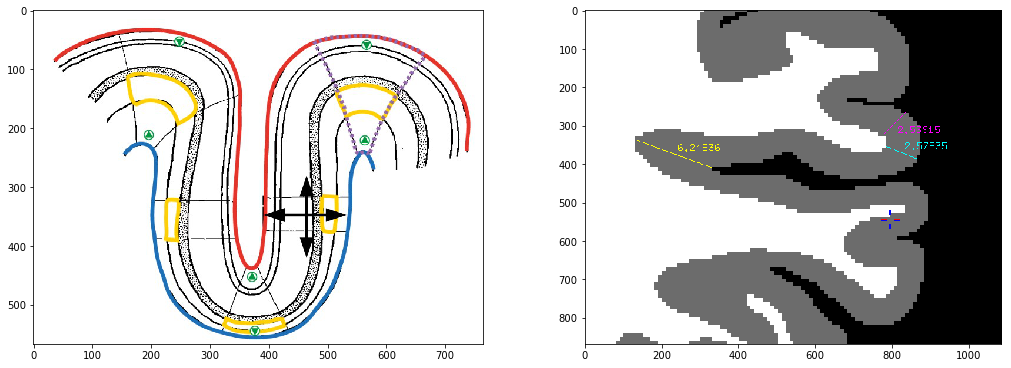

In [42]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
io.imshow('bok-profiles.png')

plt.subplot(2,2,2)
io.imshow('gray_white_columns.png')

In [3]:
o_image=io.imread('smaller_piece.jpeg')


/Users/konradwagstyl/anaconda/lib/python2.7/site-packages/PIL/Image.py:2274: DecompressionBombWarning: Image size (101067065 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


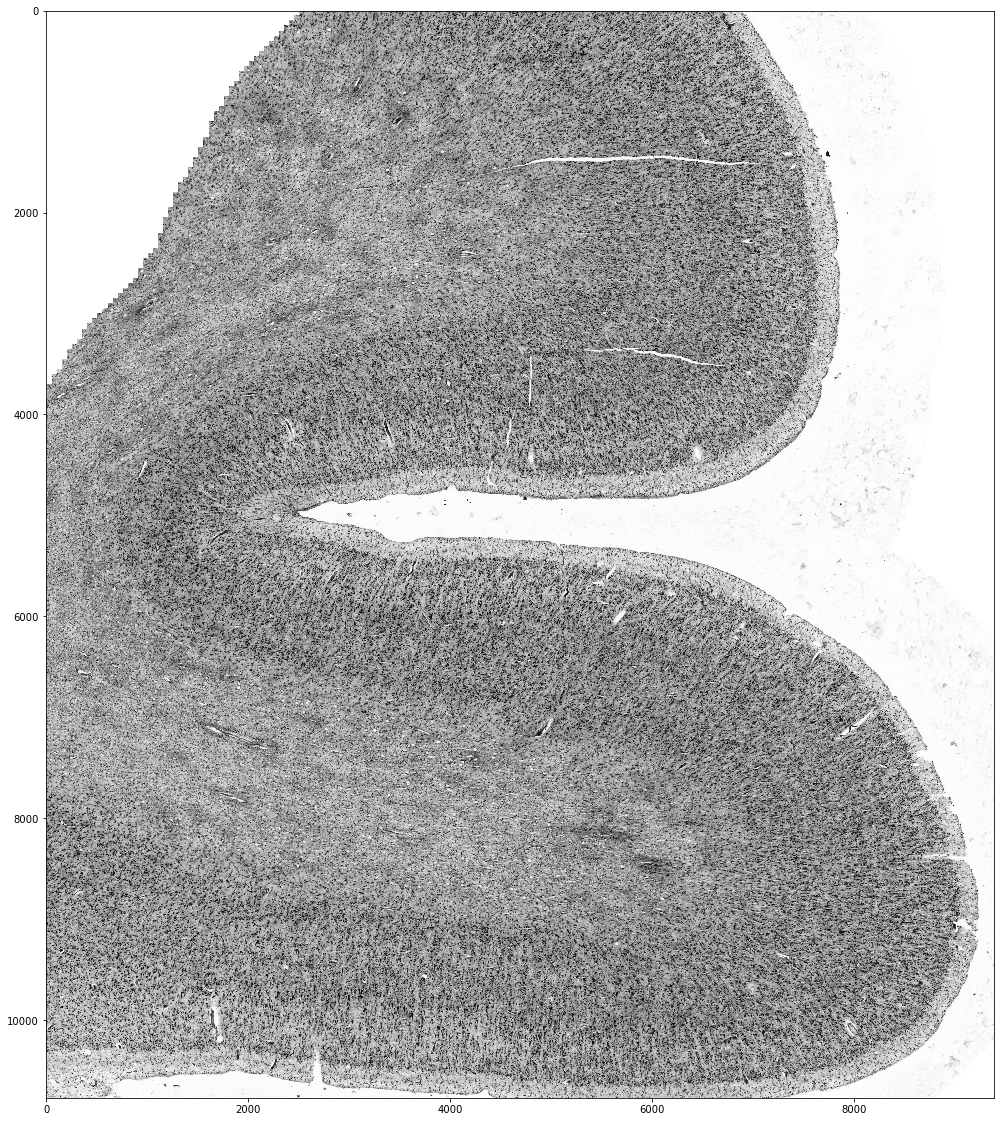

In [31]:
#plot histo image
plt.figure(figsize=(20,20))
plt.imshow(o_image,cmap='Greys_r')


In [12]:
#calculate orientation angles
sigma=50
thetas=per_pixel_angles(o_image,sigma)


/Users/konradwagstyl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/Users/konradwagstyl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


In [20]:
#summarise angles for patches of cortex
scale_factor=400
angles=angles_for_windows(thetas,scale_factor,von_mises=False)

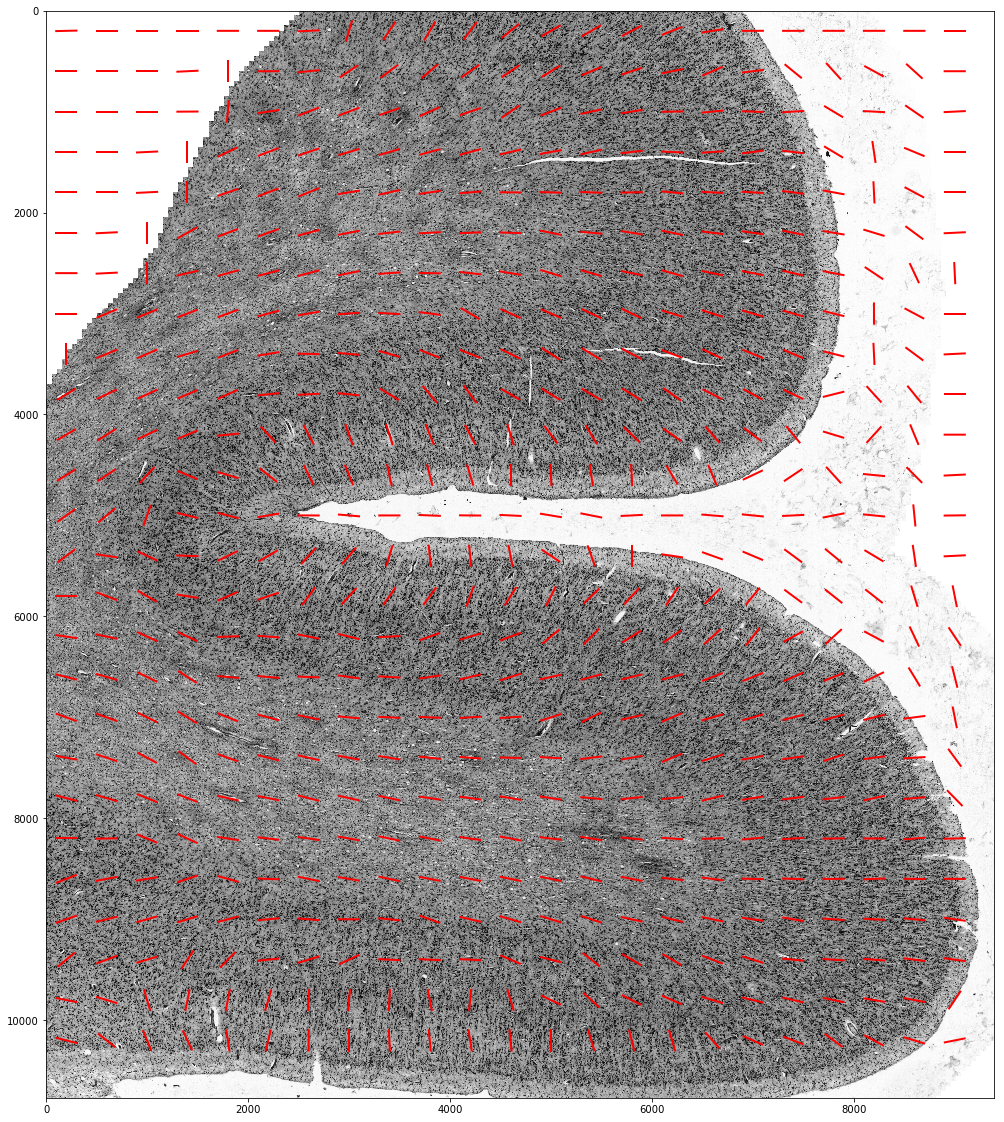

In [27]:
#plot arrows on top of image
ims=arrow_image(o_image,angles,scale_factor=scale_factor,figsize=(20,20))

In [25]:
ims.savefig('arrowfig.png')

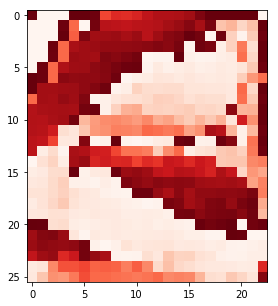

In [30]:
plt.figure(figsize=(5,5))
    
    
rgb_image(angles)